# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 18.11.2022

Мягий дедлайн: 23:59MSK 30.11.2022

Жестокий дедлайн: 23:59MSK 06.12.2022

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/43413/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ max + бонусы

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

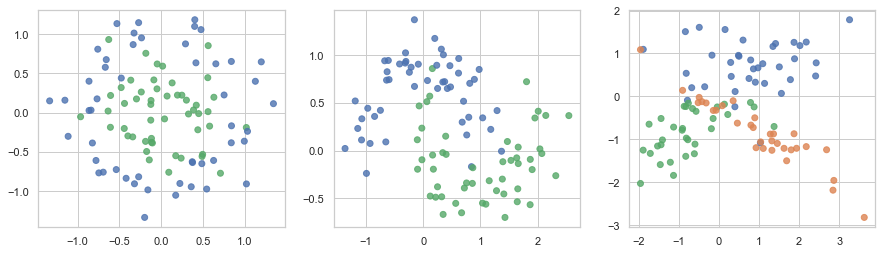

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [139]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

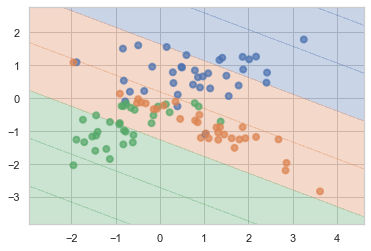

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [136]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def plot_hyperplane(X, y, i):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier().fit(X_train, y_train)
    plt.subplot(1, 3, i)
    plot_surface(clf, X_train, y_train)
    plt.title("dataset {} train acc {:.3f} test acc {:.3f}".format(i, accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))))

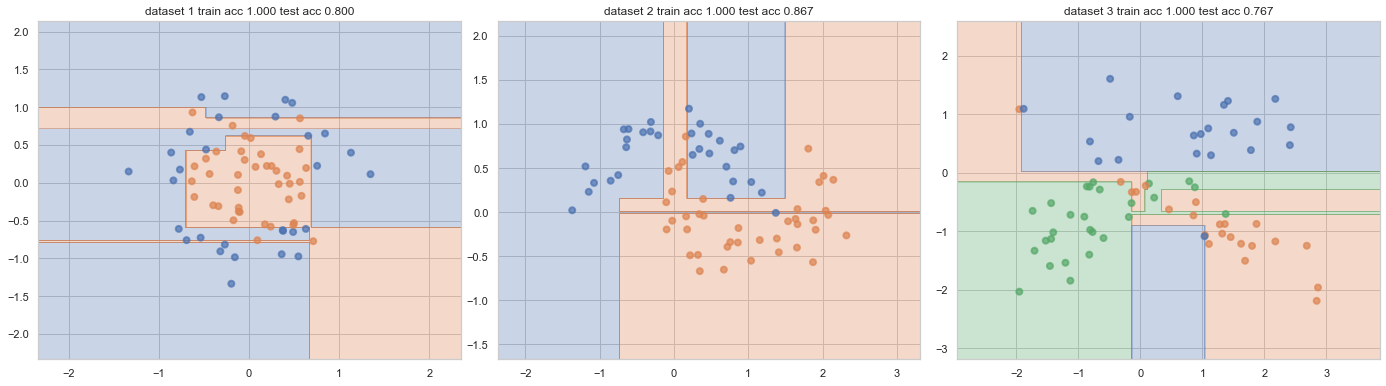

In [8]:
plt.figure(figsize=(20, 6))

for i, (X, y) in enumerate(datasets, 1):
    plot_hyperplane(X, y, i)

__Ответ:__ Добились идеальной точности на обучающей выборке, подогнав дерево под каждый объект. Разделяющая поверхность довольно грубая. Мы гарантировано переобучились.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [9]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def plot_surface_ax(clf, X, y, ax):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    
def plot_hyperplane_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    max_depths = np.arange(3, 10)
    min_samples_leafs = np.arange(1, 6)

    hparams = np.array(np.meshgrid(max_depths, min_samples_leafs)).T.reshape(-1, 2)
    
    fig, axes = plt.subplots(max_depths.shape[0], min_samples_leafs.shape[0], figsize=(20, 20))
    
    for j, (max_depth, min_samples_leaf) in enumerate(hparams):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=int(min_samples_leaf), random_state=42).fit(X_train, y_train)
        ax = axes[j // min_samples_leafs.shape[0], j % min_samples_leafs.shape[0]]
        plot_surface_ax(clf, X_train, y_train, ax)
        ax.set(title="max_depth {} min_samples_leaf {}\ntrain acc {:.3f} test acc {:.3f}".format(max_depth, min_samples_leaf, accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))))

### Датасет 1

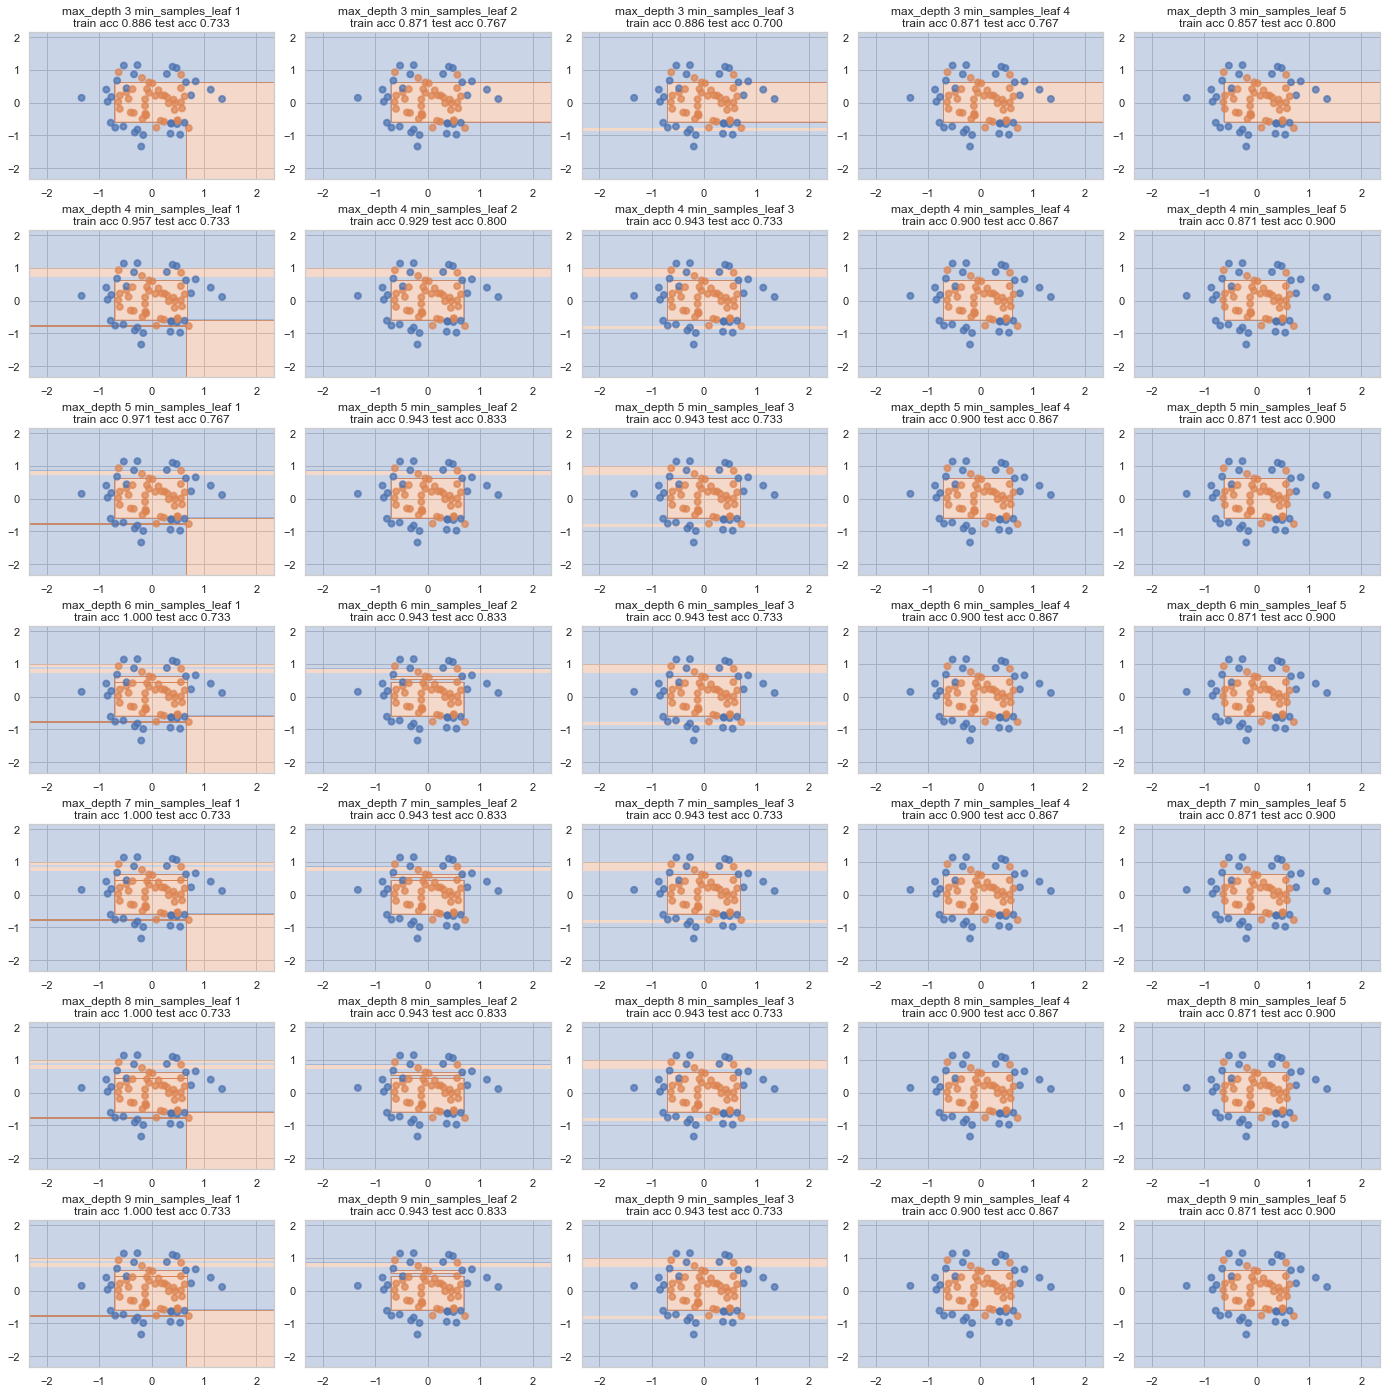

In [10]:
plot_hyperplane_reg(datasets[0][0], datasets[0][1])

### Датасет 2

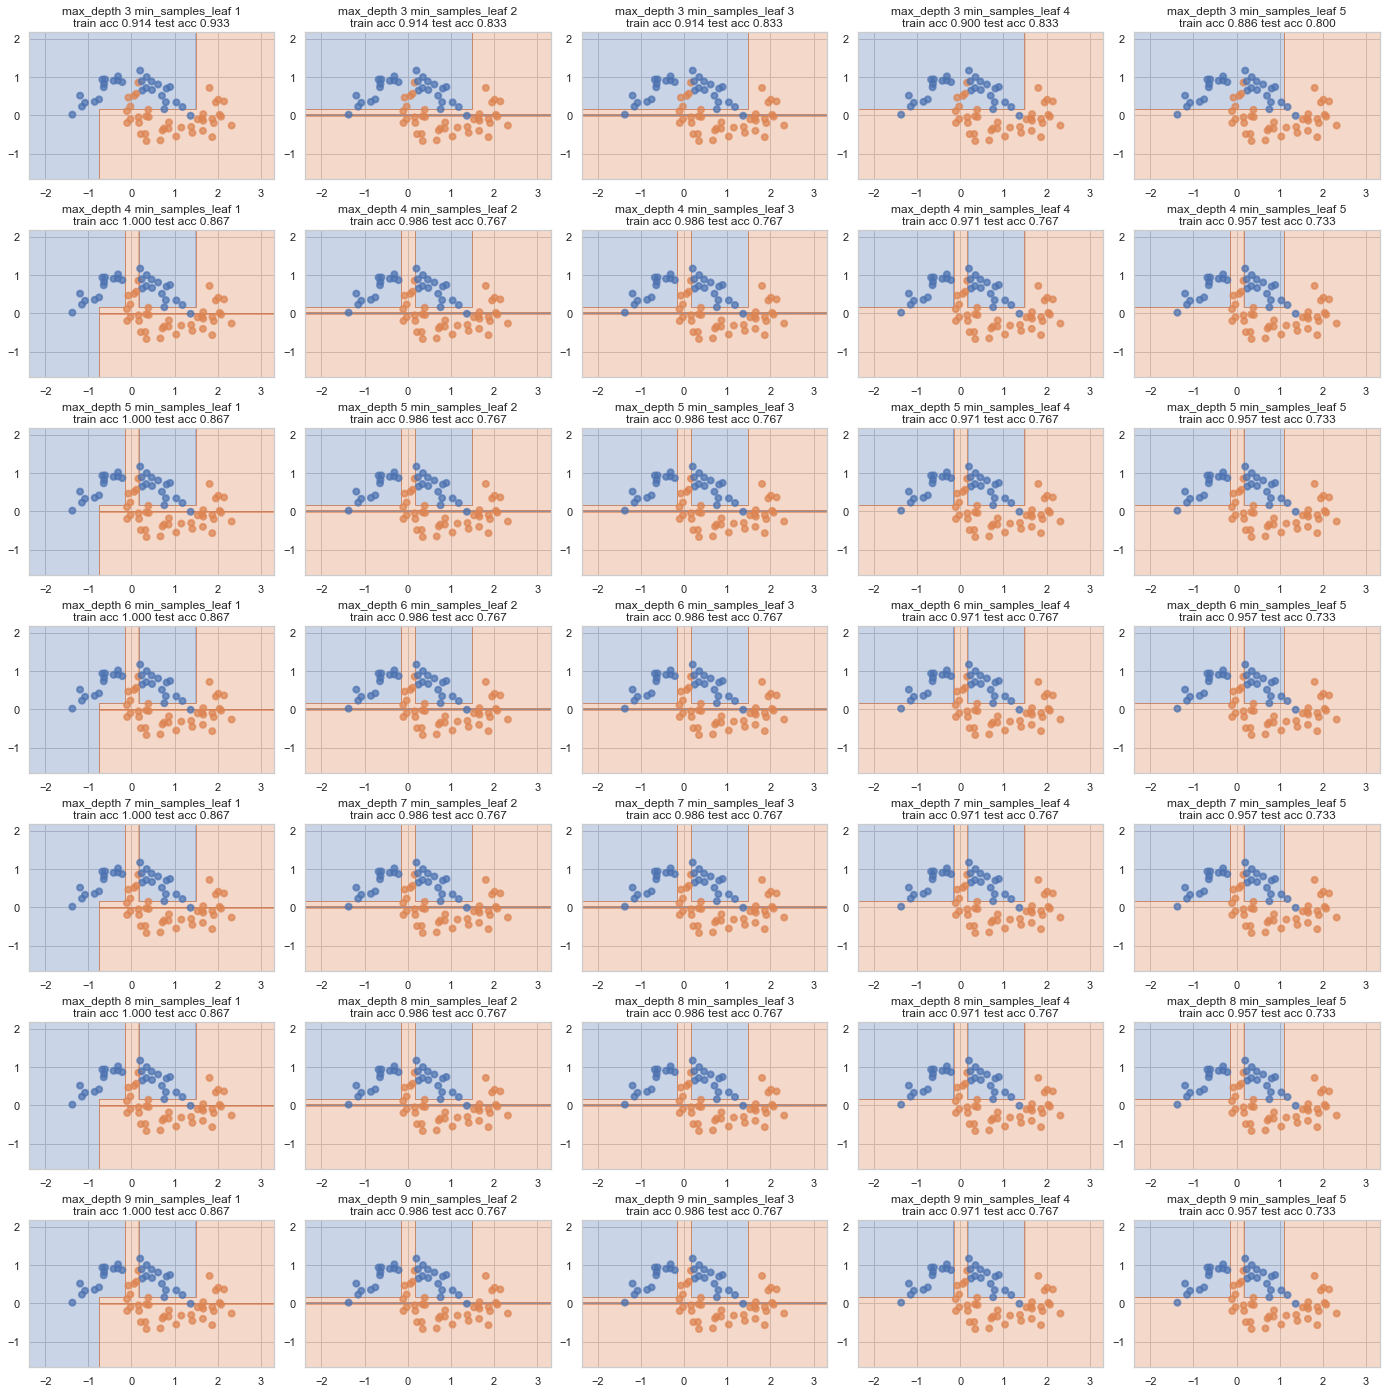

In [11]:
plot_hyperplane_reg(datasets[1][0], datasets[1][1])

### Датасет 3

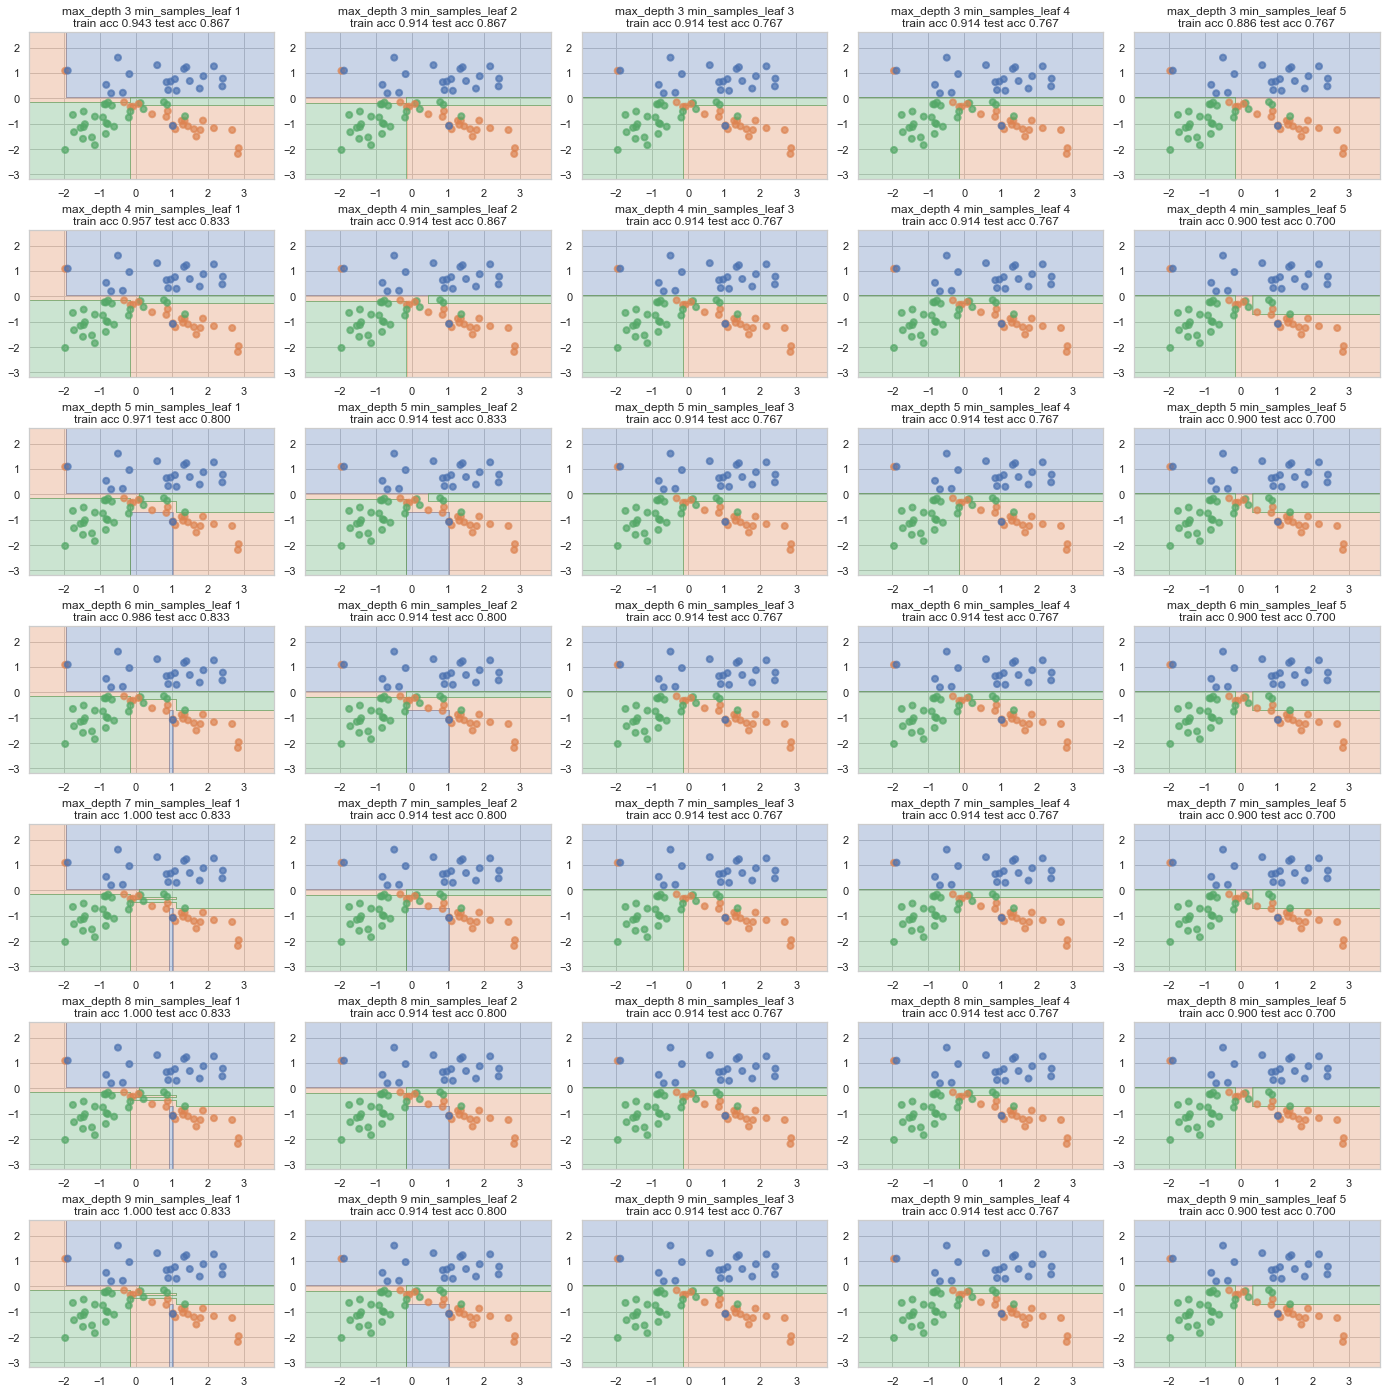

In [12]:
plot_hyperplane_reg(datasets[2][0], datasets[2][1])

__Ответ:__ Глубина дерева влияет на простоту разделяющей поверхности, чем она меньше, тем мы менее подстраиваемся под выборку и выше обобщающую способность. Также и минимальное количество объектов в листьях, чем оно больше, тем менее мы переобучаемся и не подгоняемся под 1 объект. В целом влияение этих гиперпараметров схоже среди 3 датасетов, однако где-то эффект более явный, как например, на первом. Может быть из-за простоты данных, что небольшое изменение этих гиперпараметров сильно влияет на результат.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

#### логин
kakorolev@edu.hse.ru


#### контест

https://contest.yandex.ru/contest/43413/run-report/76155486/

https://contest.yandex.ru/contest/43413/run-report/76195328/

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [2]:
from hw5code import find_best_split

In [3]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('students.csv')

df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


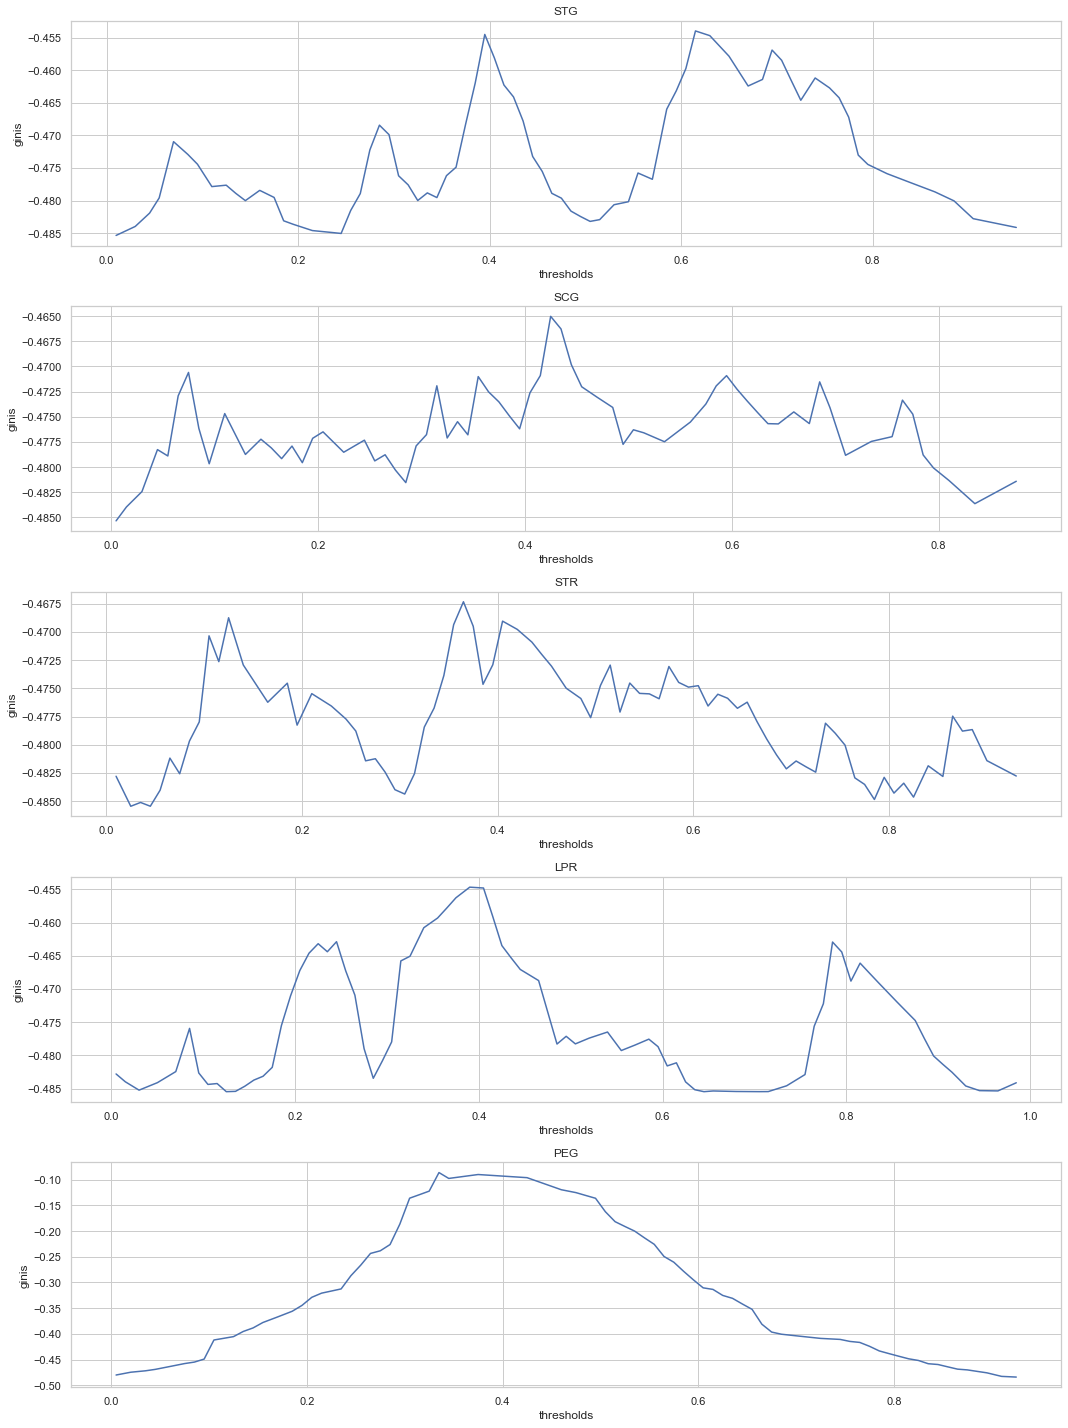

In [4]:
plt.figure(figsize=(15, 20))

for i, column in enumerate(df.columns[:-1], 1):
    thresholds, ginis, _, _ = find_best_split(df[column], df['UNS'])
    plt.subplot(len(df.columns) - 1, 1, i, xlabel="thresholds", ylabel="ginis")
    ax = sns.lineplot(x=thresholds, y=ginis)
    ax.set(title=column)
    
plt.tight_layout()

Не понял зачем тут scatterplot, нагляднее кажется boxplot.

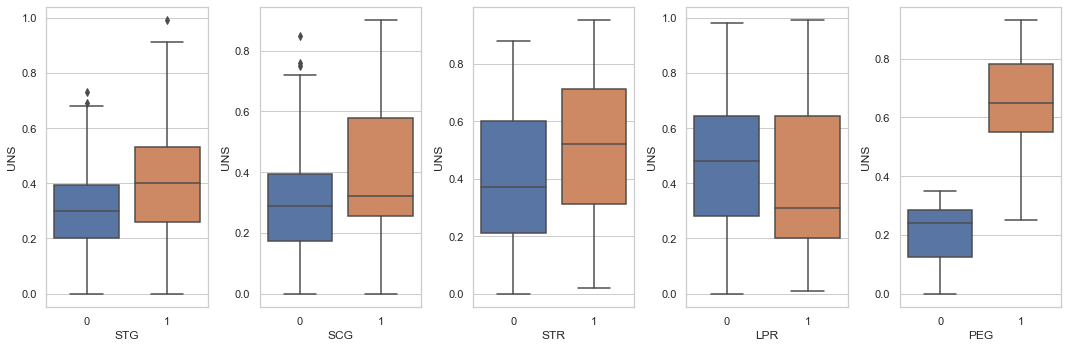

In [5]:
plt.figure(figsize=(15, 5))

for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(1, len(df.columns) - 1, i)
    ax = sns.boxplot(y=df[column], x=df['UNS'])
    ax.set(xlabel=column, ylabel="UNS")
    
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Исходя из графиков, наиболее информативным является признак PEG. У него максимальное значение критерия. По boxplot'у это тоже согласуется, так как классы довольно хорошо отделяются визуально. Наверное идеальная кривая унимодальная. Постепенно увеличивая порог, мы все лучше разделяем объекты, отщипляя их по одному, в какой-то момент достигаем максимума и потом убываем. У плохих признаков кривая будет как случайный шум, то есть признак никак не коррелирует с целевой переменной. Ниже привел примеры случайного признака и хорошего признака, предсказывающего целевую переменную.

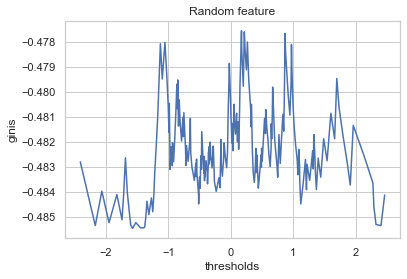

In [6]:
thresholds, ginis, _, _ = find_best_split(np.random.randn(len(df)), df['UNS'])
ax = sns.lineplot(x=thresholds, y=ginis)
ax.set(xlabel="thresholds", ylabel="ginis", title="Random feature");

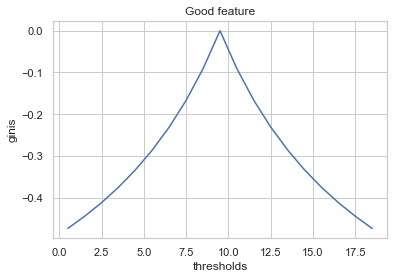

In [7]:
thresholds, ginis, _, _ = find_best_split(np.arange(20), np.concatenate((np.zeros(10), np.ones(10))))
ax = sns.lineplot(x=thresholds, y=ginis)
ax.set(xlabel="thresholds", ylabel="ginis", title="Good feature");

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [8]:
from hw5code import DecisionTree

In [9]:
shrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data')
shrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [10]:
shrooms = shrooms.apply(LabelEncoder().fit_transform)
shrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [11]:
X, y = shrooms.iloc[:,1:].to_numpy(), shrooms.iloc[:,0].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
tree = DecisionTree(['categorical'] * X_train.shape[1])
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("acc {:.5f}".format(accuracy_score(y_test, y_pred)))
print("tree depth {}".format(tree._depth))

acc 1.00000
tree depth 6


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [12]:
tic_tac = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
tic_tac = tic_tac.apply(LabelEncoder().fit_transform)
tic_tac.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


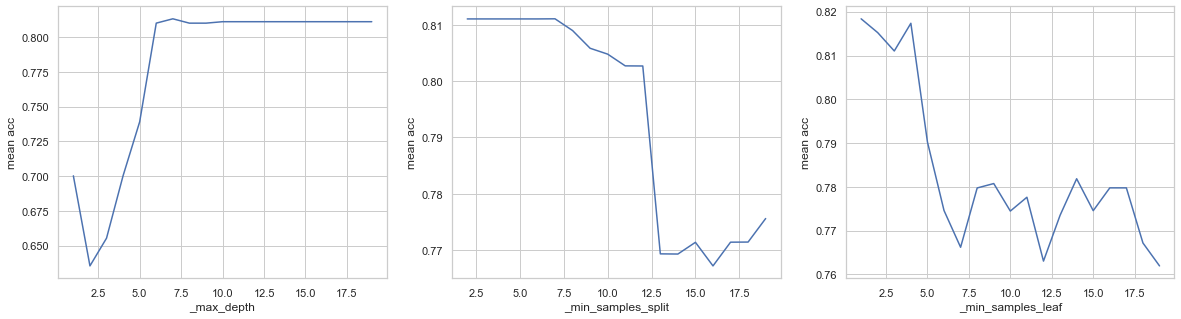

In [68]:
def decision_tree_cv(X, y):
    params_grid = [('_max_depth', np.arange(1, 20)),
                  ('_min_samples_split', np.arange(2, 20)),
                  ('_min_samples_leaf', np.arange(1, 20))]
    
    plt.figure(figsize=(20, 5))
    
    for i, (param_name, param_values) in enumerate(params_grid, 1):
        scores = []
        for param_value in tqdm(param_values, desc=f'{param_name}'):
            tree = DecisionTree(feature_types=['categorical'] * X.shape[1])
            setattr(tree, param_name, param_value)
            score = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()
            scores += [score]
        plt.subplot(1, 3, i)
        ax = sns.lineplot(x=param_values, y=scores)
        ax.set(xlabel=param_name, ylabel='mean acc')
    plt.show()
        
X, y = tic_tac.iloc[:,:-1].to_numpy(), tic_tac.iloc[:,-1].to_numpy()
decision_tree_cv(X, y)

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [71]:
tic_tac = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
tic_tac.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


In [72]:
tic_tac = tic_tac.apply(LabelEncoder().fit_transform)
tic_tac.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


In [73]:
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
cars.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [74]:
cars.unacc.value_counts()

unacc    1209
acc       384
good       69
vgood      65
Name: unacc, dtype: int64

In [75]:
cars.unacc = cars.unacc.apply(lambda val: 0 if val == 'unacc' or val == 'acc' else 1)
cars = cars.apply(LabelEncoder().fit_transform)
cars.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,3,3,0,0,2,2,0
1,3,3,0,0,2,0,0
2,3,3,0,0,1,1,0
3,3,3,0,0,1,2,0
4,3,3,0,0,1,0,0


In [76]:
cars.unacc.value_counts()

0    1593
1     134
Name: unacc, dtype: int64

In [77]:
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom


In [78]:
nursery.recommend.value_counts()

not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        1
Name: recommend, dtype: int64

In [79]:
nursery.recommend = nursery.recommend.apply(lambda val: 0 if val == 'not_recom' or val == 'recommend' else 1)
nursery = nursery.apply(LabelEncoder().fit_transform)
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,2,3,0,0,0,0,0,1,1
1,2,3,0,0,0,0,0,0,0
2,2,3,0,0,0,0,2,2,0
3,2,3,0,0,0,0,2,1,1
4,2,3,0,0,0,0,2,0,0


In [80]:
nursery.recommend.value_counts()

1    8638
0    4321
Name: recommend, dtype: int64

In [81]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def shrooms_data():
    return shrooms.iloc[:,1:].to_numpy(), shrooms.iloc[:,0].to_numpy()

def tic_tac_data():
    return tic_tac.iloc[:,:-1].to_numpy(), tic_tac.iloc[:,-1].to_numpy()

def cars_data():
    return cars.iloc[:,:-1].to_numpy(), cars.iloc[:,-1].to_numpy()

def nursery_data():
    return nursery.iloc[:,:-1].to_numpy(), nursery.iloc[:,-1].to_numpy()

def test(df, column, get_data_fn):
    X, y = get_data_fn()
    
    tree = DecisionTree(feature_types=['real'] * X.shape[1])
    df.loc[column, 'all_reals'] = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()
    
    tree = DecisionTree(feature_types=['categorical'] * X.shape[1])
    df.loc[column, 'all_categorical'] = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()
    
    Xohe = OneHotEncoder(sparse=False).fit_transform(X)
    tree = DecisionTree(feature_types=['real'] * Xohe.shape[1])
    df.loc[column, 'all_reals_ohe'] = cross_val_score(tree, Xohe, y, cv=10, scoring=make_scorer(accuracy_score)).mean()
    
    tree = DecisionTreeClassifier(random_state=42)
    df.loc[column, 'sklearn'] = cross_val_score(tree, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()
    
datasets = [('shrooms', shrooms_data), ('tic_tac', tic_tac_data), ('cars', cars_data), ('nursery', nursery_data)]
df = pd.DataFrame()

for dataset_name, get_data_fn in tqdm(datasets):
    test(df, dataset_name, get_data_fn)

In [82]:
df

,all_reals,all_categorical,all_reals_ohe,sklearn
shrooms,0.964447,0.982266,0.967649,0.961984
tic_tac,0.764178,0.811042,0.807895,0.777763
cars,0.935102,0.868786,0.826939,0.944371
nursery,0.999923,0.999923,0.999923,0.999846


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

In [87]:
df = df.reset_index().rename(columns={'index': 'dataset'})
df

,dataset,all_reals,all_categorical,all_reals_ohe,sklearn
0,shrooms,0.964447,0.982266,0.967649,0.961984
1,tic_tac,0.764178,0.811042,0.807895,0.777763
2,cars,0.935102,0.868786,0.826939,0.944371
3,nursery,0.999923,0.999923,0.999923,0.999846


**Ответ:** Почти для всех наборов данных, алгоритм с чисто категориальными признаками работает лучше, кроме датасета cars. Чуть ниже поймем почему так может быть. Ранжирование для mushrooms, tic_tac и nursery одинаковое: categorical, reals + ohe, sklearn, reals в порядке убывания accuracy. Только cars выделяется на их фоне. Все модели обучаются одинаково, случайности нет, возможно кроме sklearn версии. Categorical будет лучше остальных очевидно, так как сами признаки категориальные, а если мы будем считать их вещественными и вводить порядок, то это имеет мало смысла.

In [124]:
cars_experiment = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
cars_experiment.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [128]:
cars_experiment['vhigh'].value_counts()

med      432
low      432
high     432
vhigh    431
Name: vhigh, dtype: int64

In [126]:
cars_experiment['vhigh.1'].value_counts()

med      432
low      432
high     432
vhigh    431
Name: vhigh.1, dtype: int64

In [133]:
(cars_experiment['vhigh'] != cars_experiment['vhigh.1']).sum()

1296

In [134]:
cars_experiment[cars_experiment['vhigh'] != cars_experiment['vhigh.1']]

,vhigh,vhigh.1,2,2.1,small,low,unacc
107,vhigh,high,2,2,small,low,unacc
108,vhigh,high,2,2,small,med,unacc
109,vhigh,high,2,2,small,high,unacc
110,vhigh,high,2,2,med,low,unacc
111,vhigh,high,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1614,low,med,5more,more,med,med,good
1615,low,med,5more,more,med,high,vgood
1616,low,med,5more,more,big,low,unacc
1617,low,med,5more,more,big,med,good


Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [143]:
# тут должна быть фотография дерева...